# Prepocessing

In [149]:
import os

def remove_non_jpg_files(folder_path):
    """Removes all files from a folder that do not have the .jpg extension."""
    for filename in os.listdir(folder_path):
        if not filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)


# List of folder paths to process
folder_paths = [
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Healthy',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Miner',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Phoma',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Rust',
]

# Process each folder
for folder in folder_paths:
    remove_non_jpg_files(folder)

In [150]:
#cek label
from pathlib import Path
image_dir = Path('/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [151]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/kaggle/input/capstone-project/drive-download-...,Rust
1,/kaggle/input/capstone-project/drive-download-...,Miner
2,/kaggle/input/capstone-project/drive-download-...,Healthy
3,/kaggle/input/capstone-project/drive-download-...,Healthy
4,/kaggle/input/capstone-project/drive-download-...,Miner


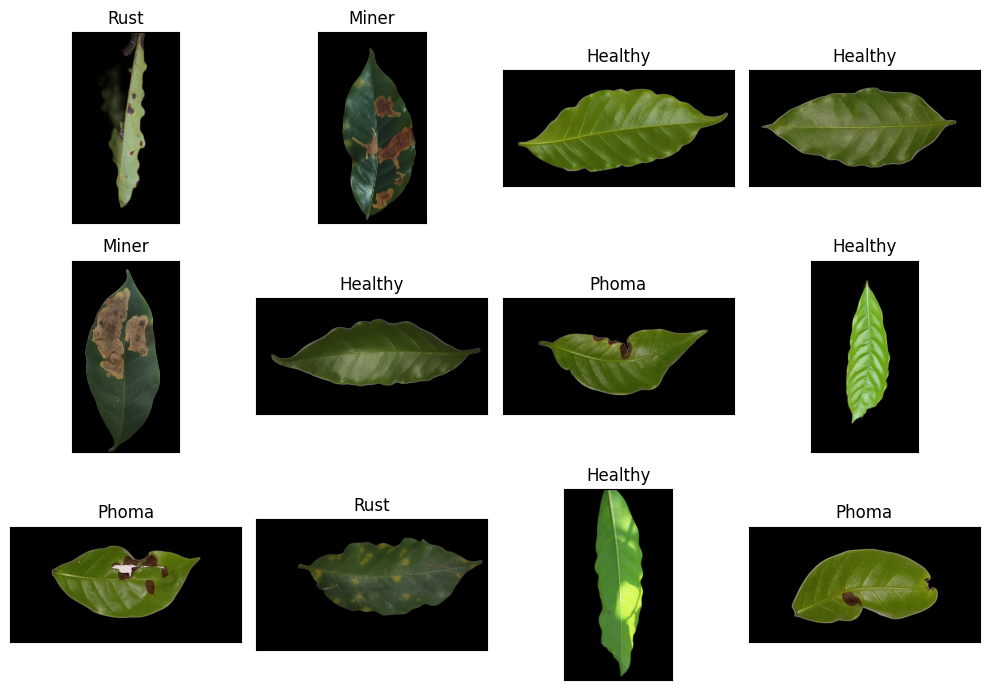

In [152]:
# Display some pictures of the dataset with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

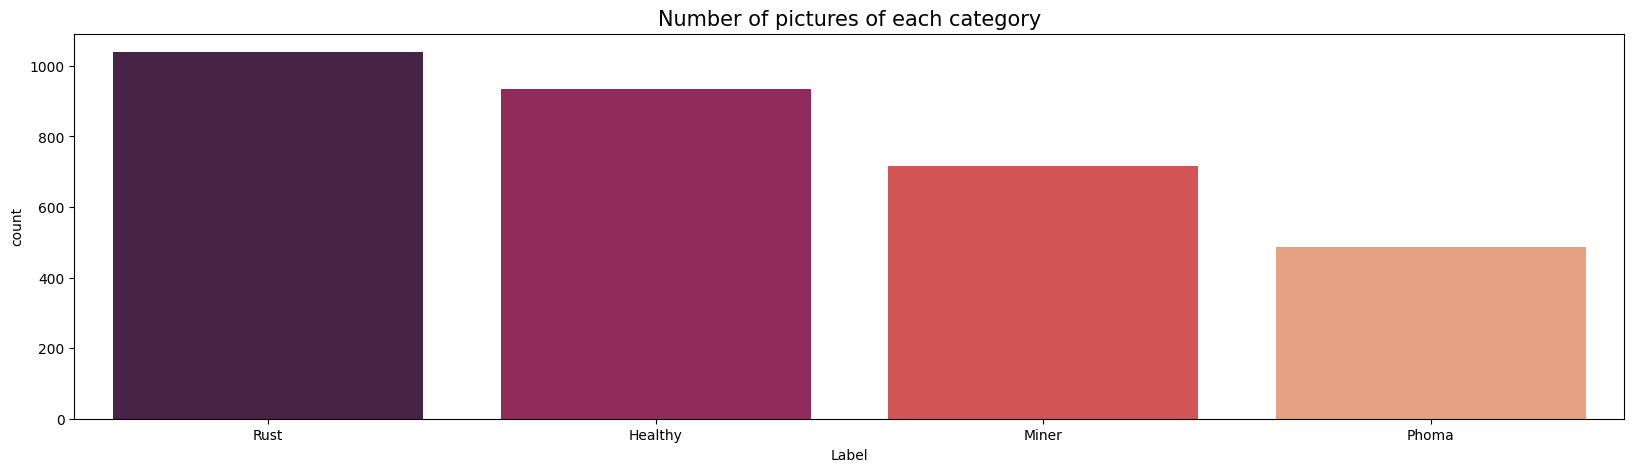

In [153]:

# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [154]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [155]:
import tensorflow as tf #Import tensorflow 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( # Use tf.keras.preprocessing.image.ImageDataGenerator
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Use tf.keras.preprocessing.image.ImageDataGenerator

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2859 validated image filenames belonging to 4 classes.
Found 318 validated image filenames belonging to 4 classes.


# Built Model SENet


In [156]:
from tensorflow.keras.layers import (
    Input, Conv2D, GlobalAveragePooling2D, Dense, Add, BatchNormalization, 
    Activation, MaxPooling2D, Dropout, LayerNormalization, GlobalMaxPooling2D,
    Multiply, Concatenate, Lambda
)
from tensorflow.keras.models import Model
import tensorflow as tf

def se_block(input_feature, ratio=16):
    channel = input_feature.shape[-1]
    
    # Use both average and max pooling
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    
    # Process both pooling results
    avg_fc = Dense(channel // ratio, activation='relu')(avg_pool)
    max_fc = Dense(channel // ratio, activation='relu')(max_pool)
    
    avg_fc = Dense(channel)(avg_fc)
    max_fc = Dense(channel)(max_fc)
    
    # Combine the features
    scale = Add()([avg_fc, max_fc])
    scale = Activation('sigmoid')(scale)
    
    return Multiply()([input_feature, scale])

def cbam_block(input_feature, ratio=16):
    channel = input_feature.shape[-1]
    
    # Channel Attention Module
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    
    shared_mlp_1 = Dense(channel // ratio, activation='relu')
    shared_mlp_2 = Dense(channel)
    
    avg_pool = shared_mlp_1(avg_pool)
    avg_pool = shared_mlp_2(avg_pool)
    
    max_pool = shared_mlp_1(max_pool)
    max_pool = shared_mlp_2(max_pool)
    
    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = LayerNormalization()(channel_attention)
    channel_attention = Activation('sigmoid')(channel_attention)
    
    channel_refined = Multiply()([input_feature, channel_attention])
    
    # Spatial Attention Module
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    
    spatial_attention = Conv2D(1, (7, 7), padding='same', use_bias=False)(concat)
    spatial_attention = BatchNormalization()(spatial_attention)
    spatial_attention = Activation('sigmoid')(spatial_attention)
    
    return Multiply()([channel_refined, spatial_attention])

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def senet_attention_model(input_shape, classes):
    inputs = Input(shape=input_shape)
    
    # Initial convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # Residual blocks with SE and CBAM
    for filters in [64, 128, 256]:
        x = residual_block(x, filters)
        x = se_block(x)
        x = cbam_block(x)
        x = Dropout(0.2)(x)
    
    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = LayerNormalization()(x)
    outputs = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model = senet_attention_model(input_shape=(224, 224, 3), classes=4)

# Use a learning rate schedule
initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=10000, decay_rate=0.9
# )

optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Model summary
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_126[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_170      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 56, 56,    │          0 │ activation_170[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_127[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_171      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 56, 56,    │     36,928 │ activation_171[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_128[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_96 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_172      │ (None, 56, 56,    │          0 │ add_96[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_172[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ activation_172[0… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_212 (Dense)   │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_213 (Dense)   │ (None, 4)         │        260 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_214 (Dense)   │ (None, 64)        │        320 │ dense_212[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_215 (Dense)   │ (None, 64)        │        320 │ dense_213[0][0] 

 Total params: 1,406,282 (5.36 MB)

 Trainable params: 1,403,588 (5.35 MB)

 Non-trainable params: 2,694 (10.52 KB)

In [157]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('val_accuracy')>=0.95):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
callbacks = EarlyStoppingAtMaxAccuracy()

In [158]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
checkpoint_path = '/kaggle/working/SENet.keras'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan

In [159]:
history = model.fit(
    train_data,
    batch_size=32,
    validation_data=validasi_data,
    epochs=15,
    callbacks=[callbacks,checkpoint_callback]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.3633 - auc_10: 0.6619 - loss: 1.3785
Epoch 1: val_loss improved from inf to 1.43112, saving model to /kaggle/working/SENet.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 110s 937ms/step - accuracy: 0.3643 - auc_10: 0.6629 - loss: 1.3763 - val_accuracy: 0.3396 - val_auc_10: 0.5955 - val_loss: 1.4311
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.6467 - auc_10: 0.8838 - loss: 0.8064
Epoch 2: val_loss did not improve from 1.43112
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 766ms/step - accuracy: 0.6471 - auc_10: 0.8841 - loss: 0.8055 - val_accuracy: 0.3082 - val_auc_10: 0.5951 - val_loss: 2.0332
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.7765 - auc_10: 0.9513 - loss: 0.5139
Epoch 3: val_loss did not improve from 1.43112
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 772ms/step - accuracy: 0.7767 - auc_10: 0.9514 - loss: 0.5136 - val_accuracy: 0.3113 - val_auc_10: 0.5746 - val_loss: 2.7538
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/

# Plotting Accuration After Training and Test Model

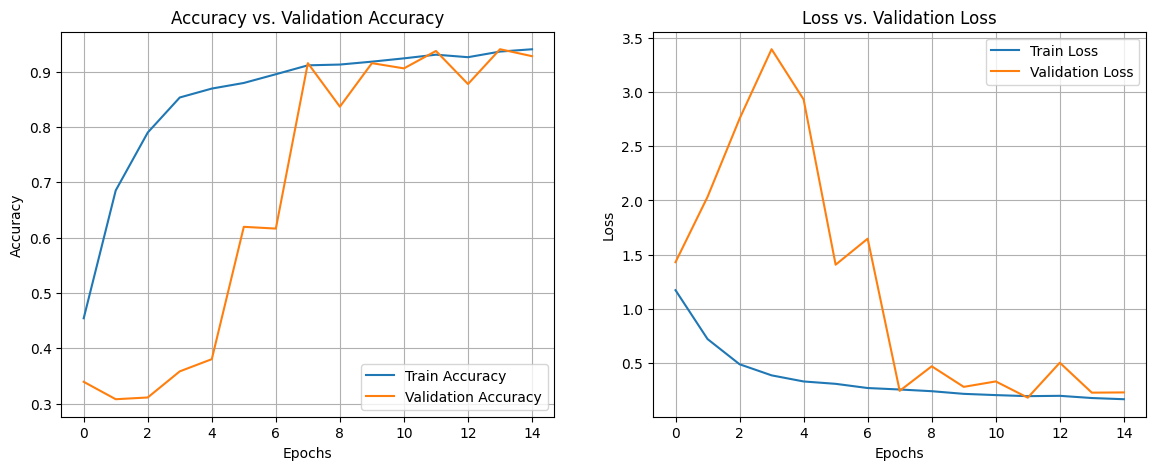

In [160]:
import matplotlib.pyplot as plt

# Asumsikan 'history' adalah hasil dari training model
# Contoh: history = model.fit(...)

# Plot Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Validation Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.show()

In [161]:
# Predict the label of the test_images
import numpy as np
pred = model.predict(validasi_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:4]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step
The first 5 predictions: ['Rust', 'Rust', 'Healthy', 'Rust']


In [162]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(validasi_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Healthy       0.95      0.95      0.95        83
       Miner       0.93      0.86      0.90        74
       Phoma       0.88      1.00      0.94        53
        Rust       0.93      0.92      0.93       108

    accuracy                           0.93       318
   macro avg       0.92      0.93      0.93       318
weighted avg       0.93      0.93      0.93       318



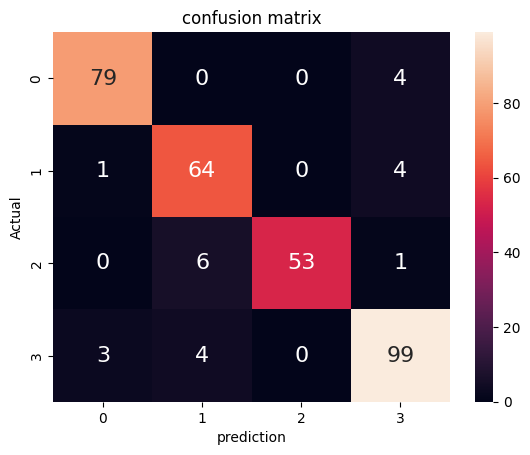

In [163]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

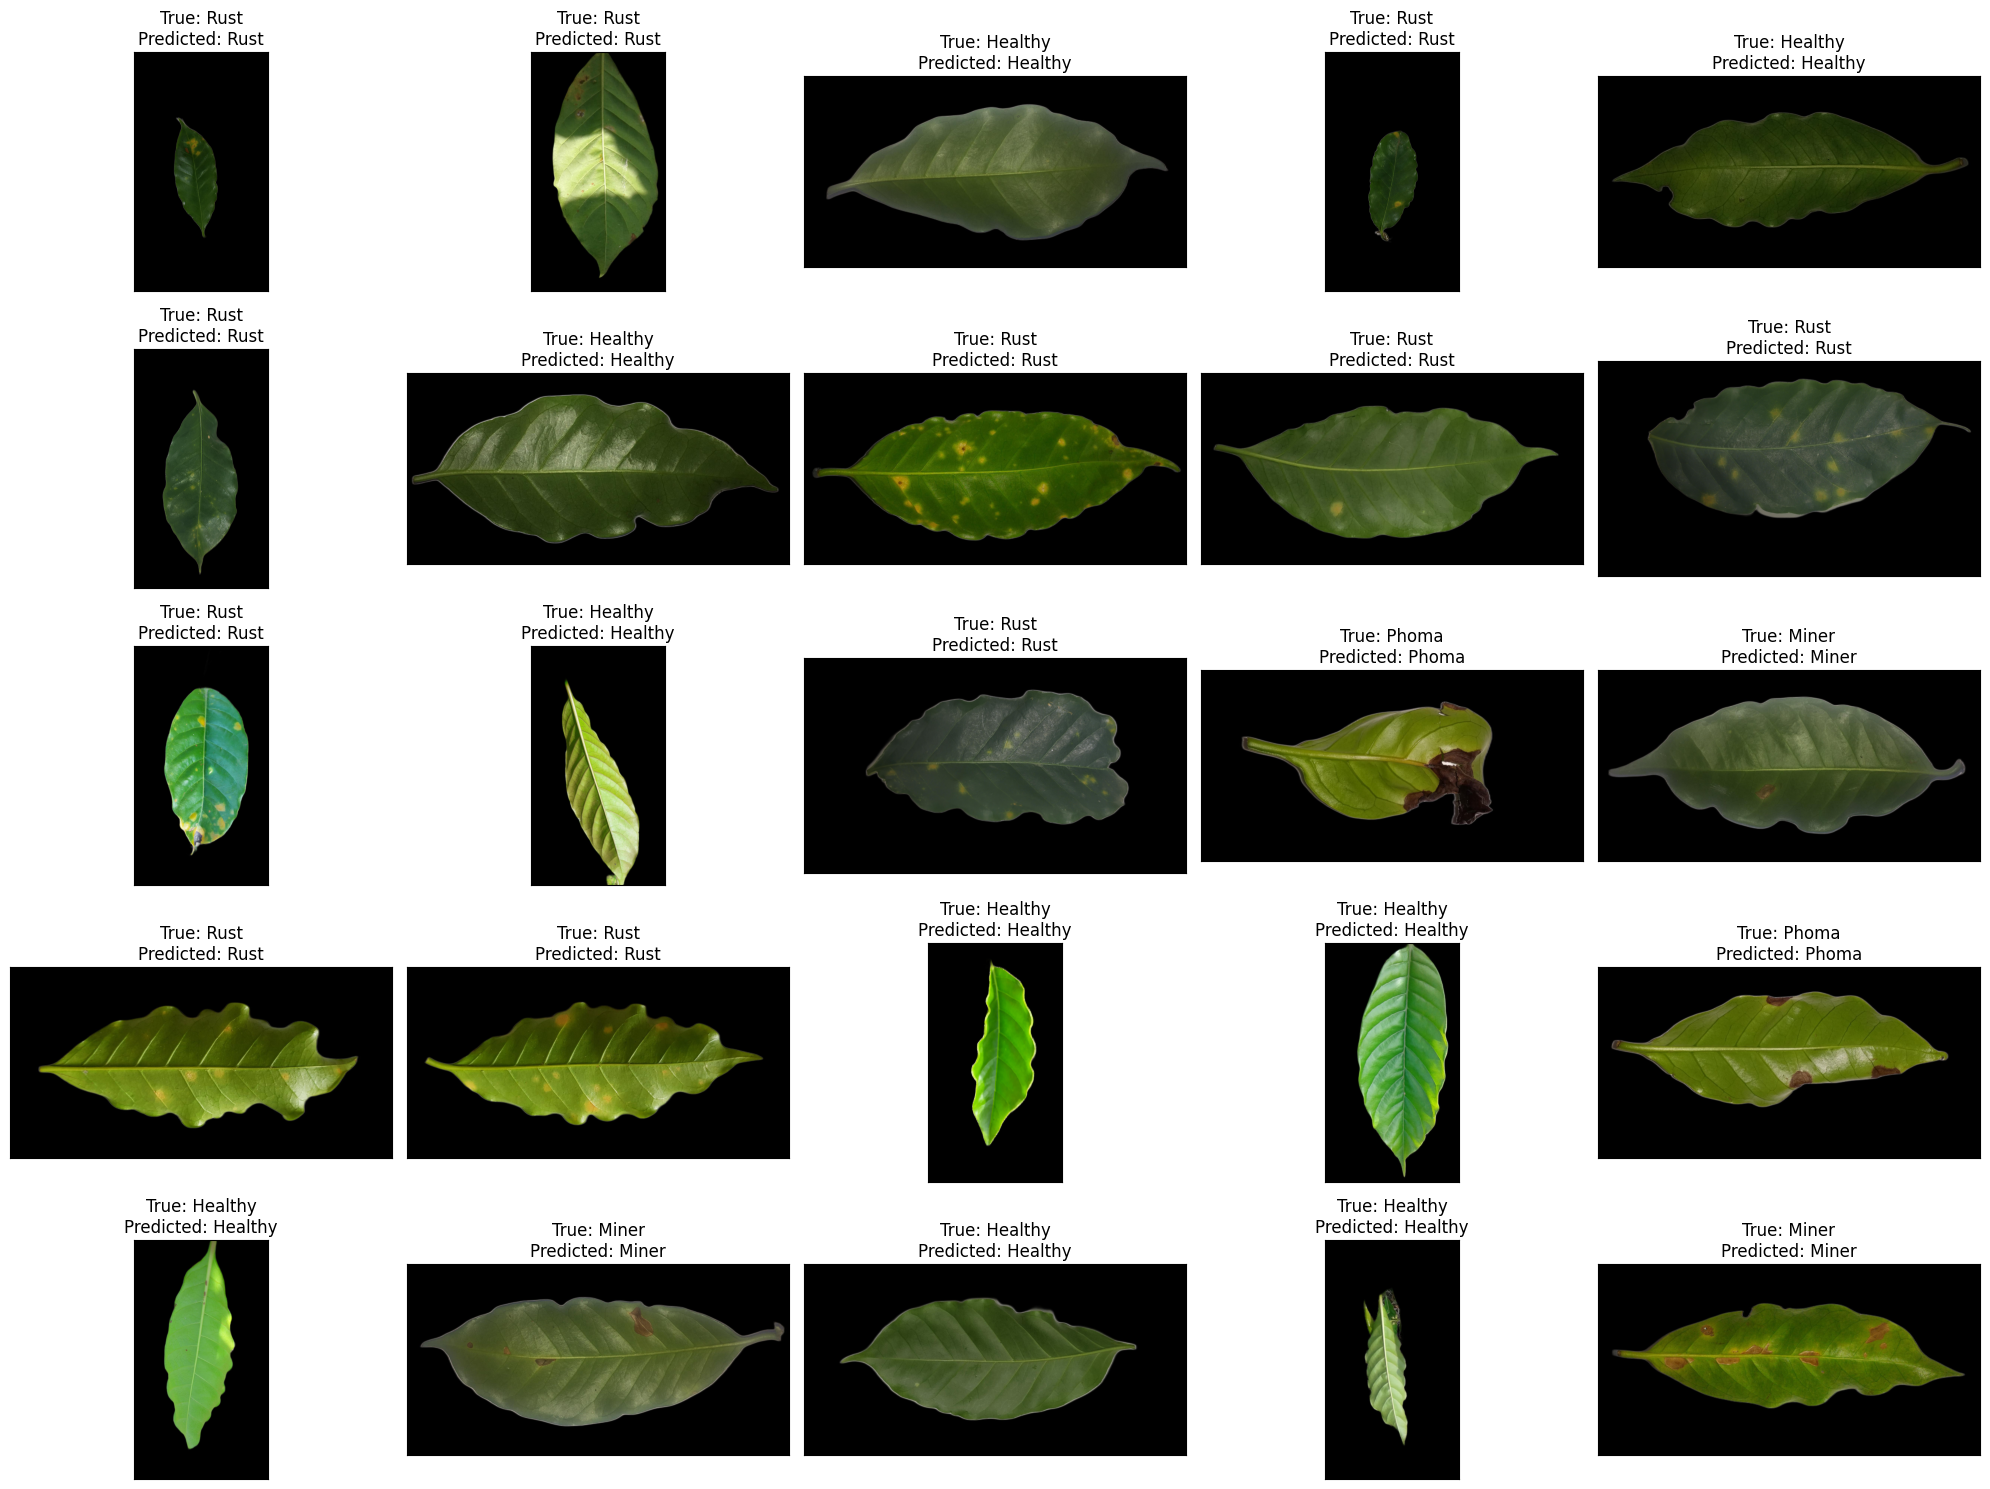

In [164]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# Saved Model to .h5

In [165]:
MODEL_BASE_PATH = "/content/drive/MyDrive/ens2_inception/"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "model.1.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/ens2_inception/H5/model.1.h5...


In [166]:
model.evaluate(validasi_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.9594 - auc_10: 0.9909 - loss: 0.1548


[0.23012669384479523, 0.9276729822158813, 0.9866170287132263]